In [264]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib as mpl

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from itertools import product

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Идеи для фич

1) лаги/средние/...
2) курс доллара
3) дата налогового дня?
4) праздники
5) время отдыха
6) ...

# Загрузка данных

In [265]:
df = pd.read_excel("/home/owner/Documents/DEV/Time_series/Project 1_2024.xlsx", parse_dates=['Date'], index_col='Date')

In [266]:
df.index.dtype

dtype('<M8[ns]')

# График временного ряда

<Axes: xlabel='Date', ylabel='Balance'>

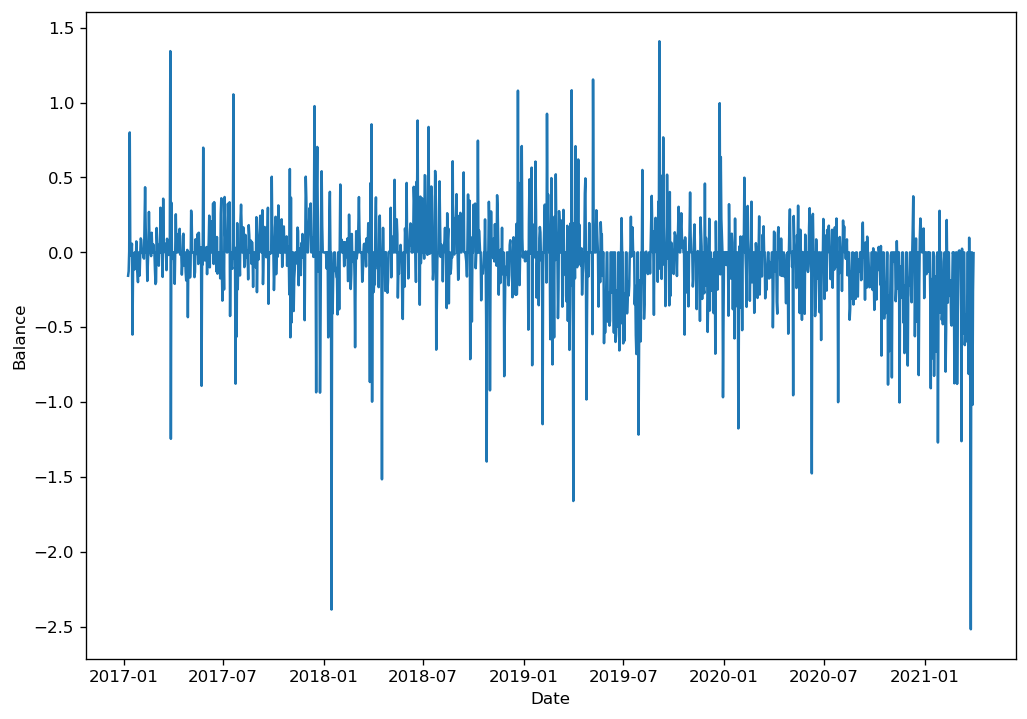

In [267]:
sns.lineplot(x = df.index, y = df.Balance)


# Тест Дики-Фуллера для проверки на стационарность

In [268]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [269]:
adf_test(df.Balance)

Results of Dickey-Fuller Test:
Test Statistic                   -4.114101
p-value                           0.000918
#Lags Used                       20.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
dtype: float64


In [270]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [271]:
check_stationarity(df.Balance)

ADF Statistic: -4.114101
p-value: 0.000918
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


# Разложение на компоненты (попытка)

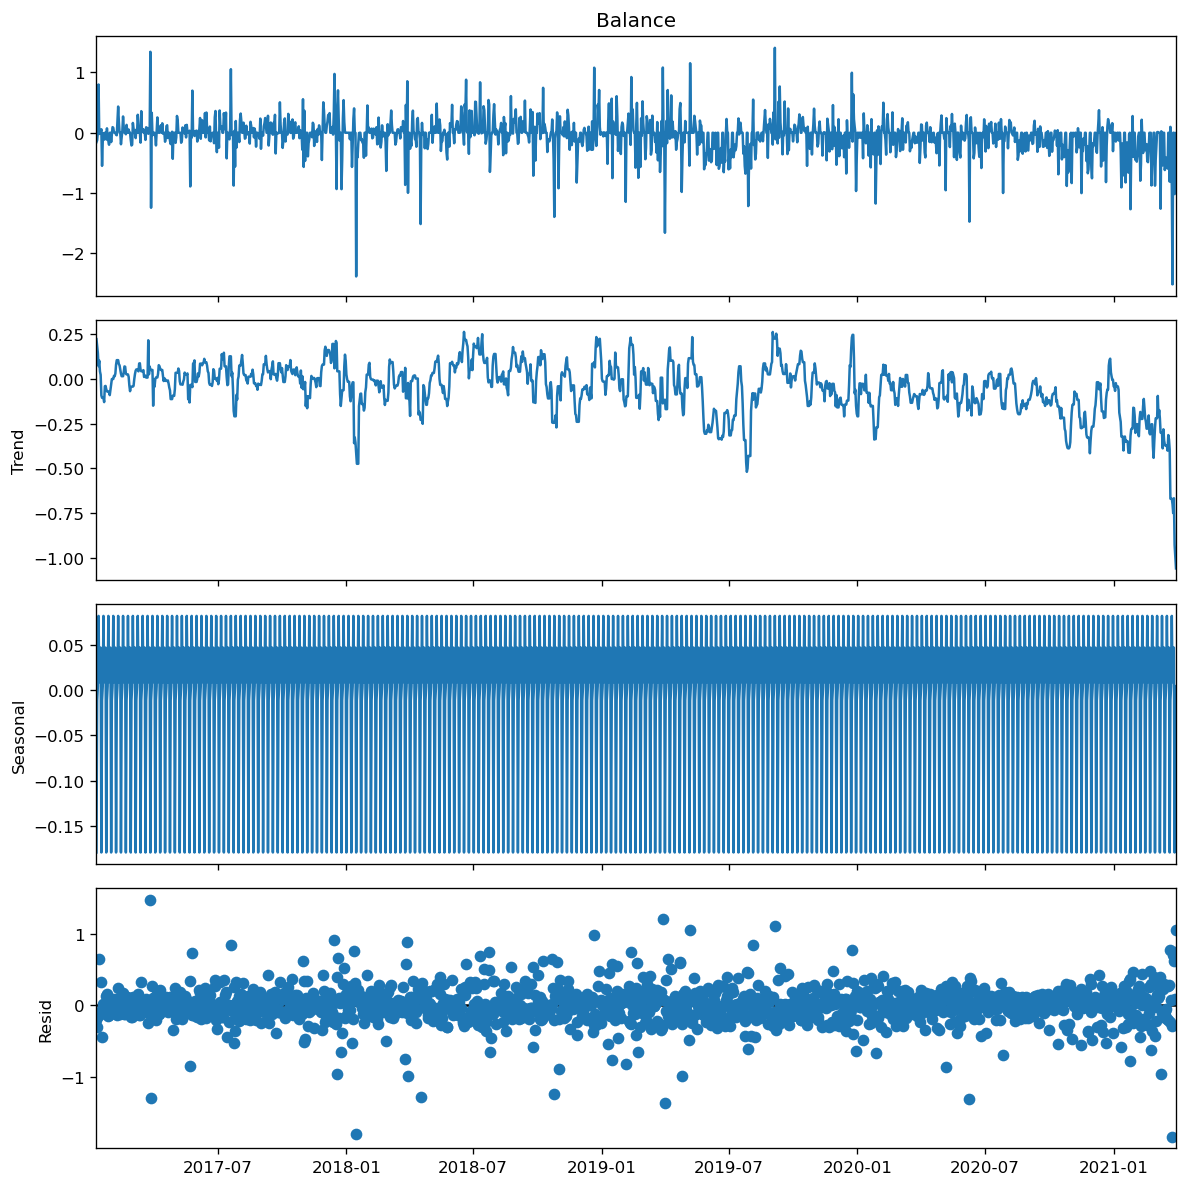

In [272]:
# Additive Decomposition
result_add = seasonal_decompose(df.Balance, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

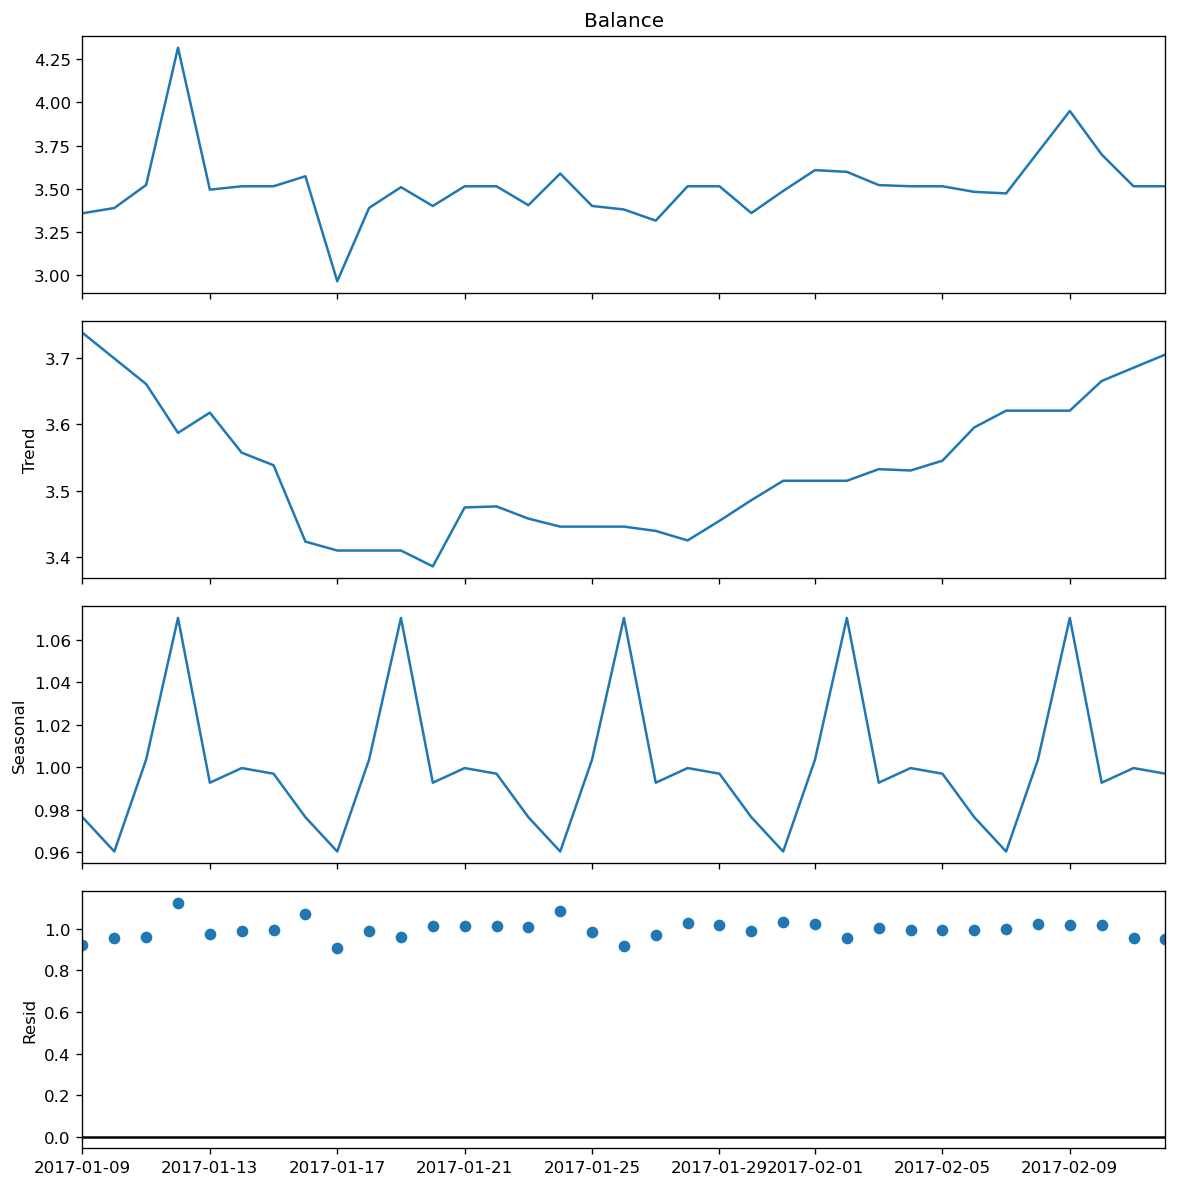

In [273]:
df.posBalance = df.Balance + np.abs(df.Balance.min()) + 1

result_add = seasonal_decompose(df.posBalance[:35], model='multiplicative', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

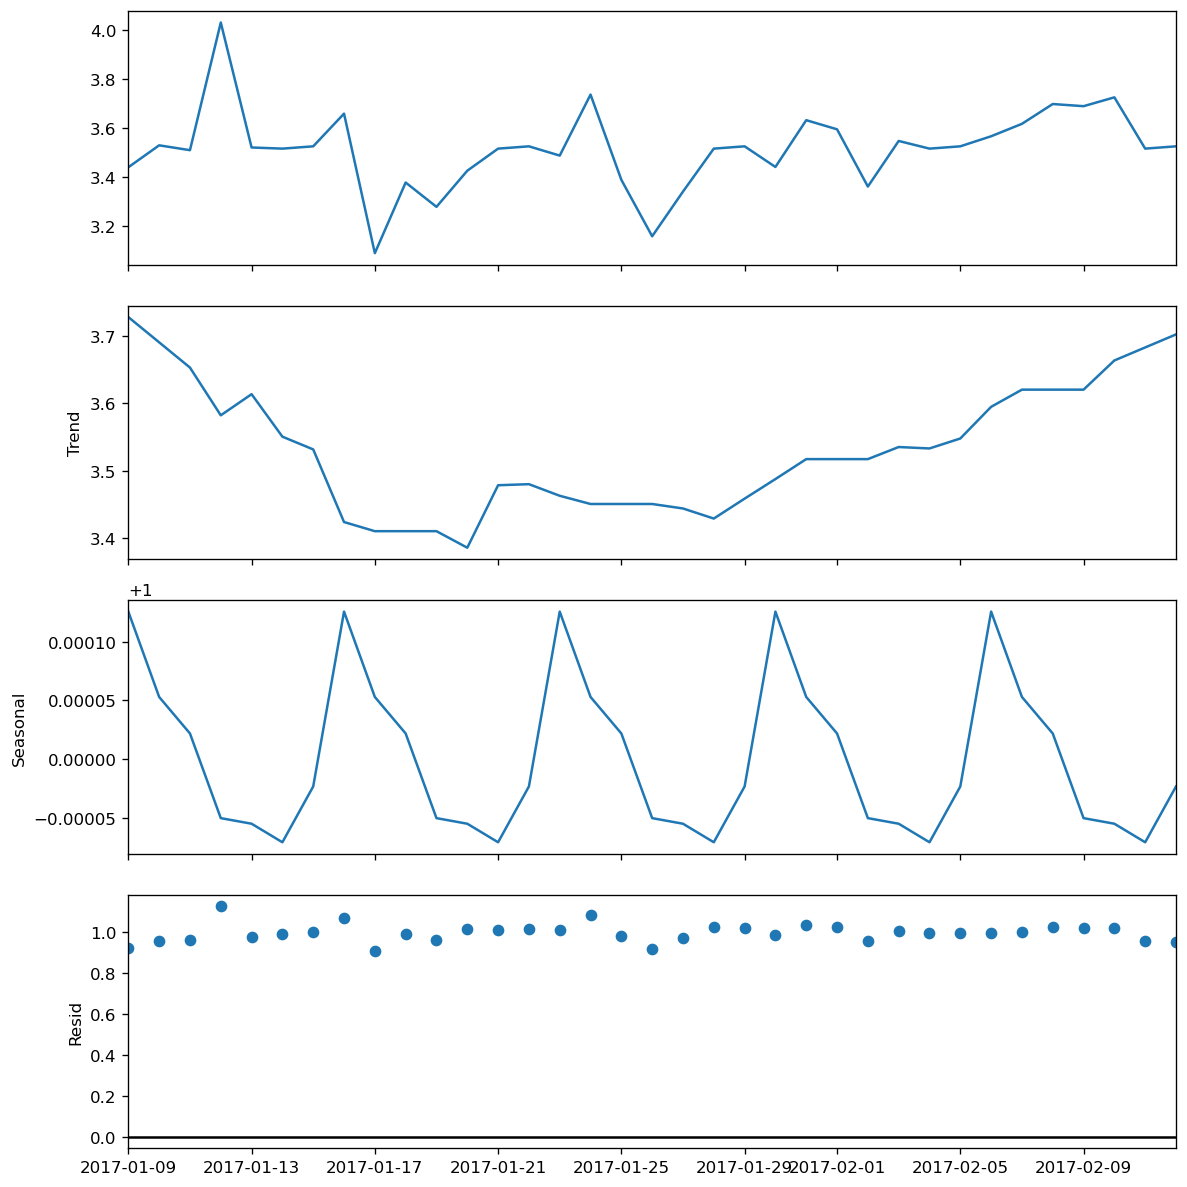

In [274]:
result_add.seasonal

result_add = seasonal_decompose(df.posBalance[:35] / result_add.seasonal, model='multiplicative', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

# Стабилизация Дисперсии (?)

# Изучение ACF/PACF

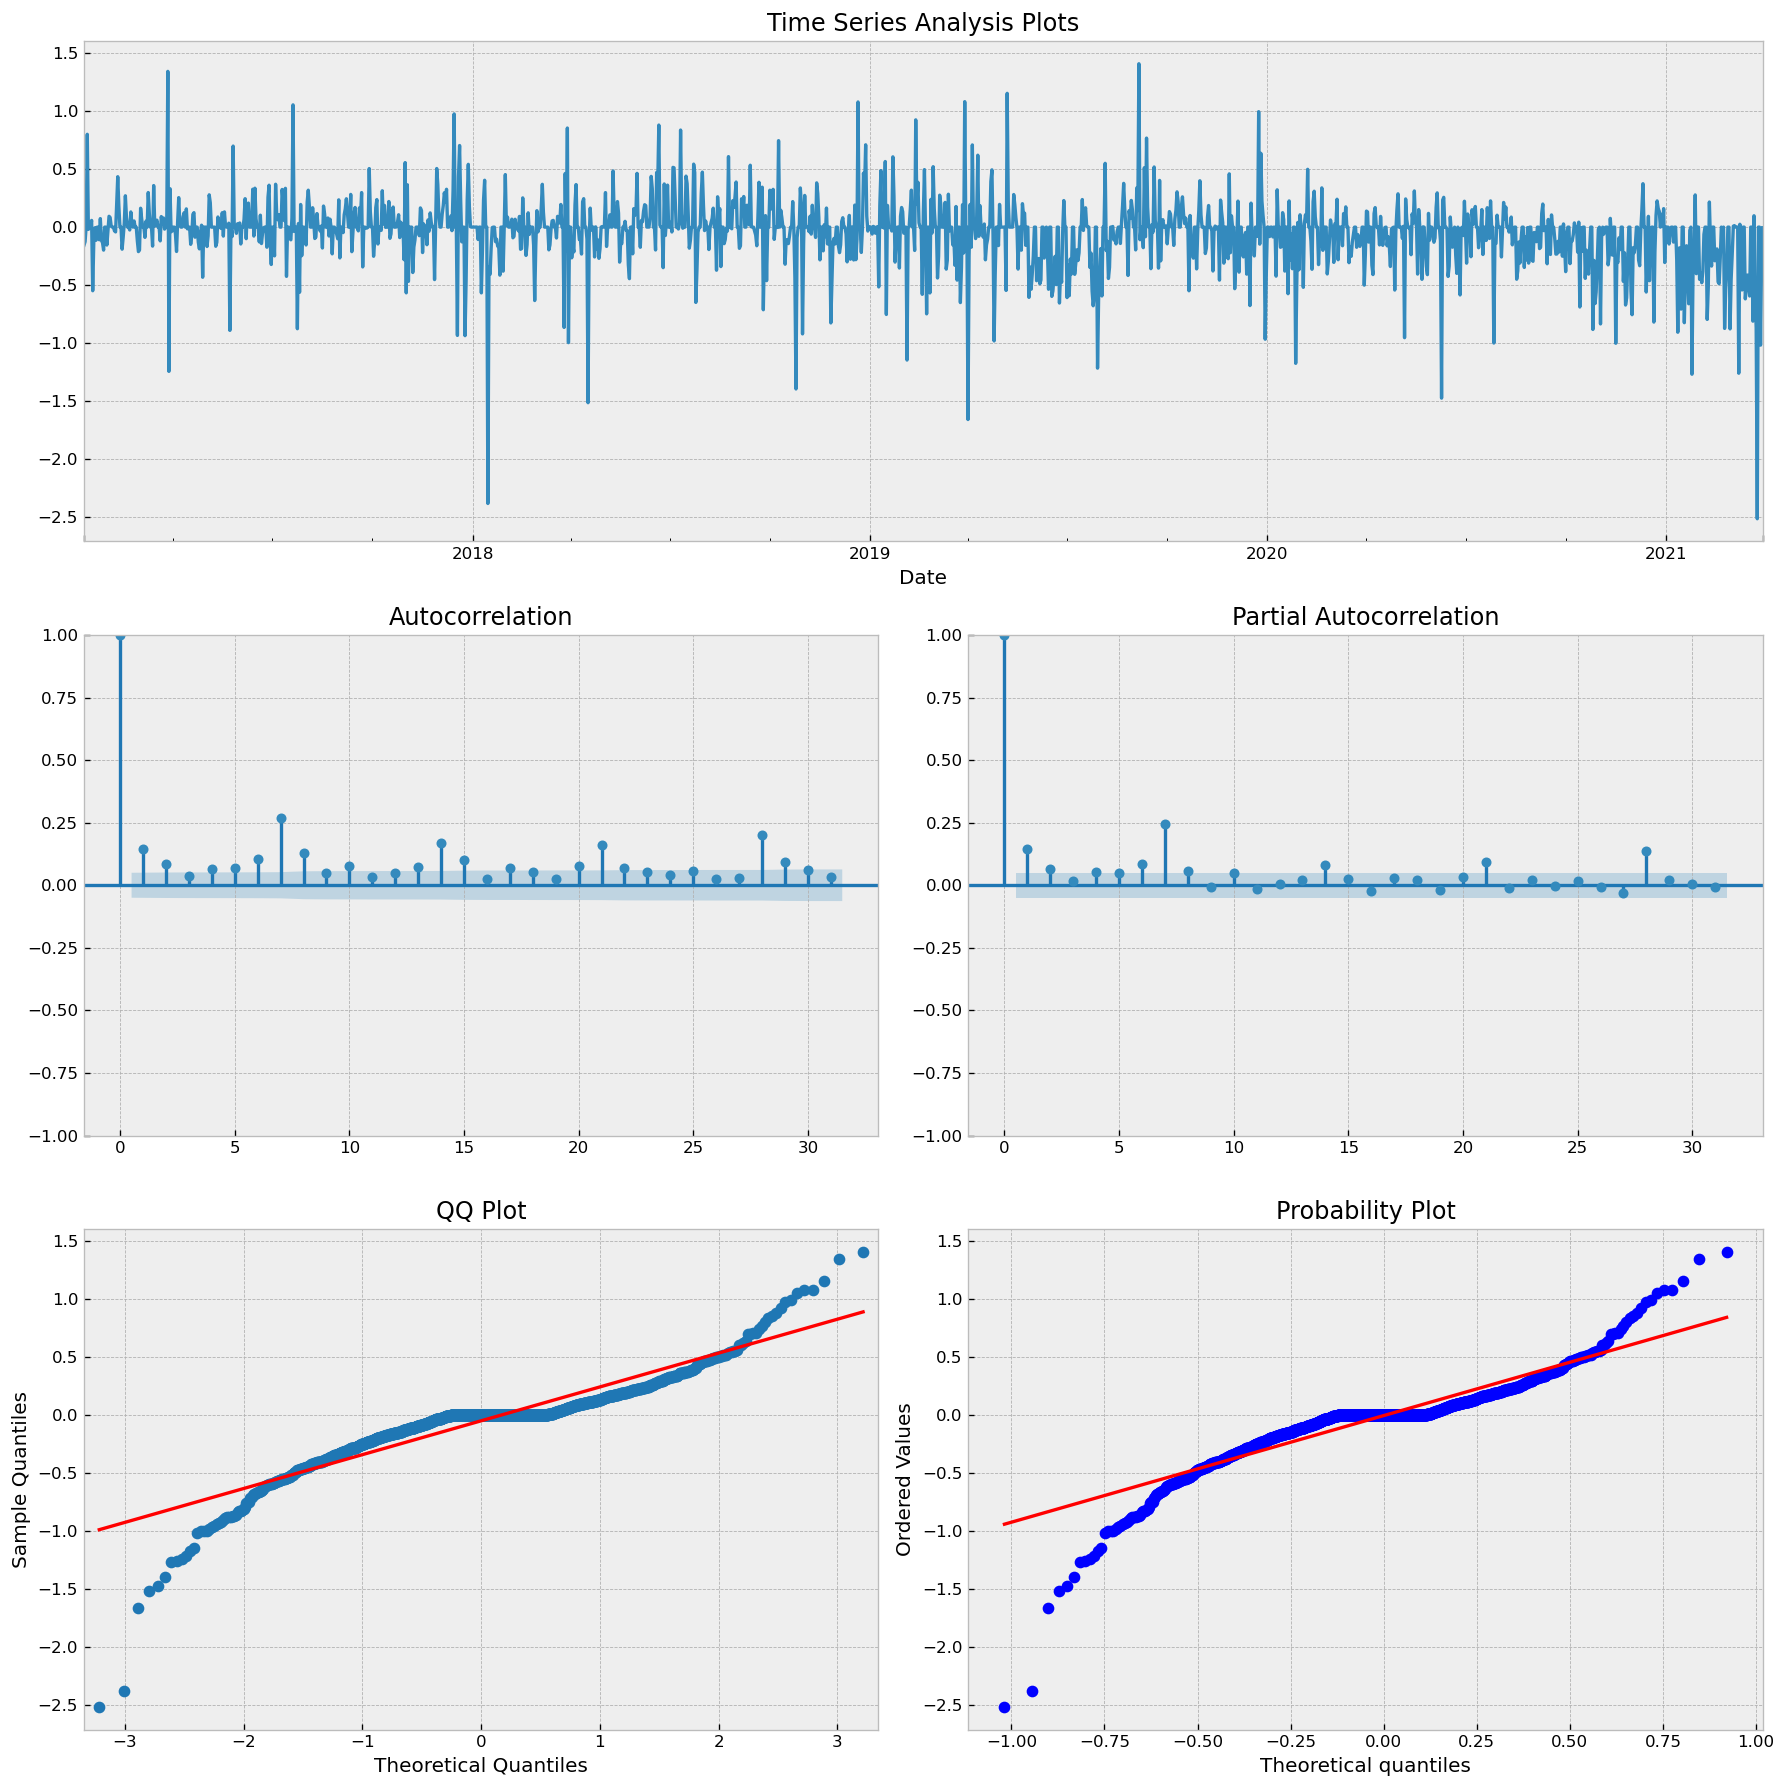

In [275]:
def tsplot(y, lags=None, figsize=(15, 15), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

np.random.seed(1)

# plot of discrete white noise
tsplot(df.Balance, lags=31)

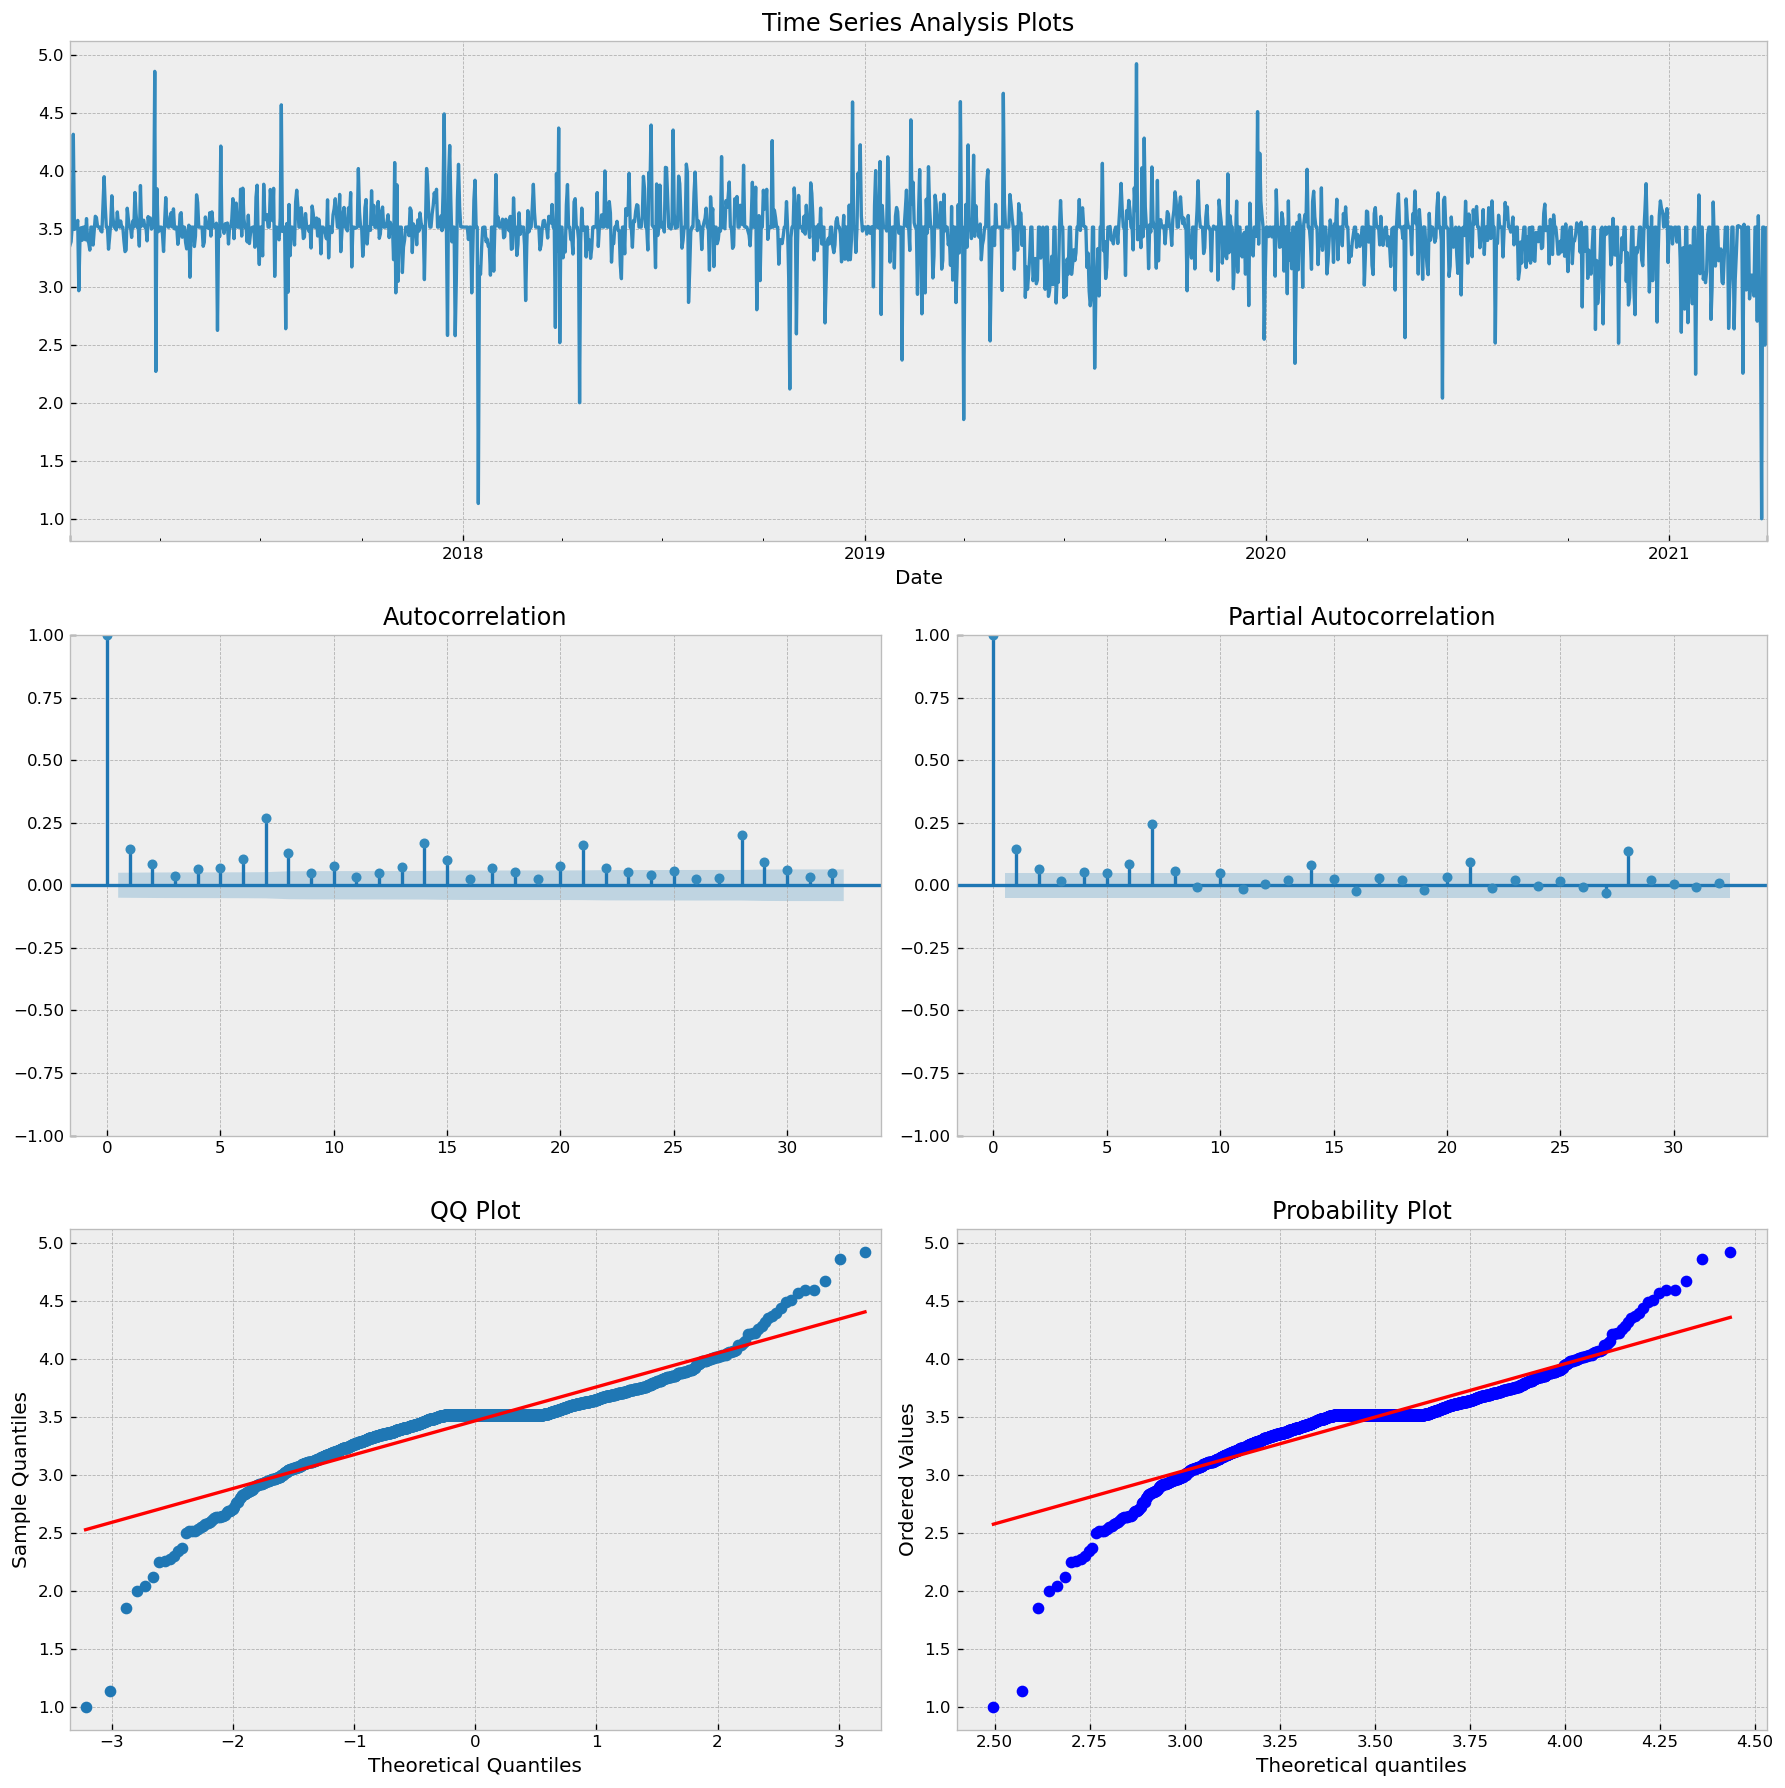

In [276]:
tsplot(df.posBalance)

Похоже на SARIMA(p=1, i=0, q=0, P=1, I=0, Q=0, S=7)

Попробуем избавиться от сезонности дифференцированием

In [277]:
seasonality = 7

df.shift7 = df.posBalance - df.posBalance.shift(7)
df.shift7x2 = df.shift7 - df.shift7.shift(7)

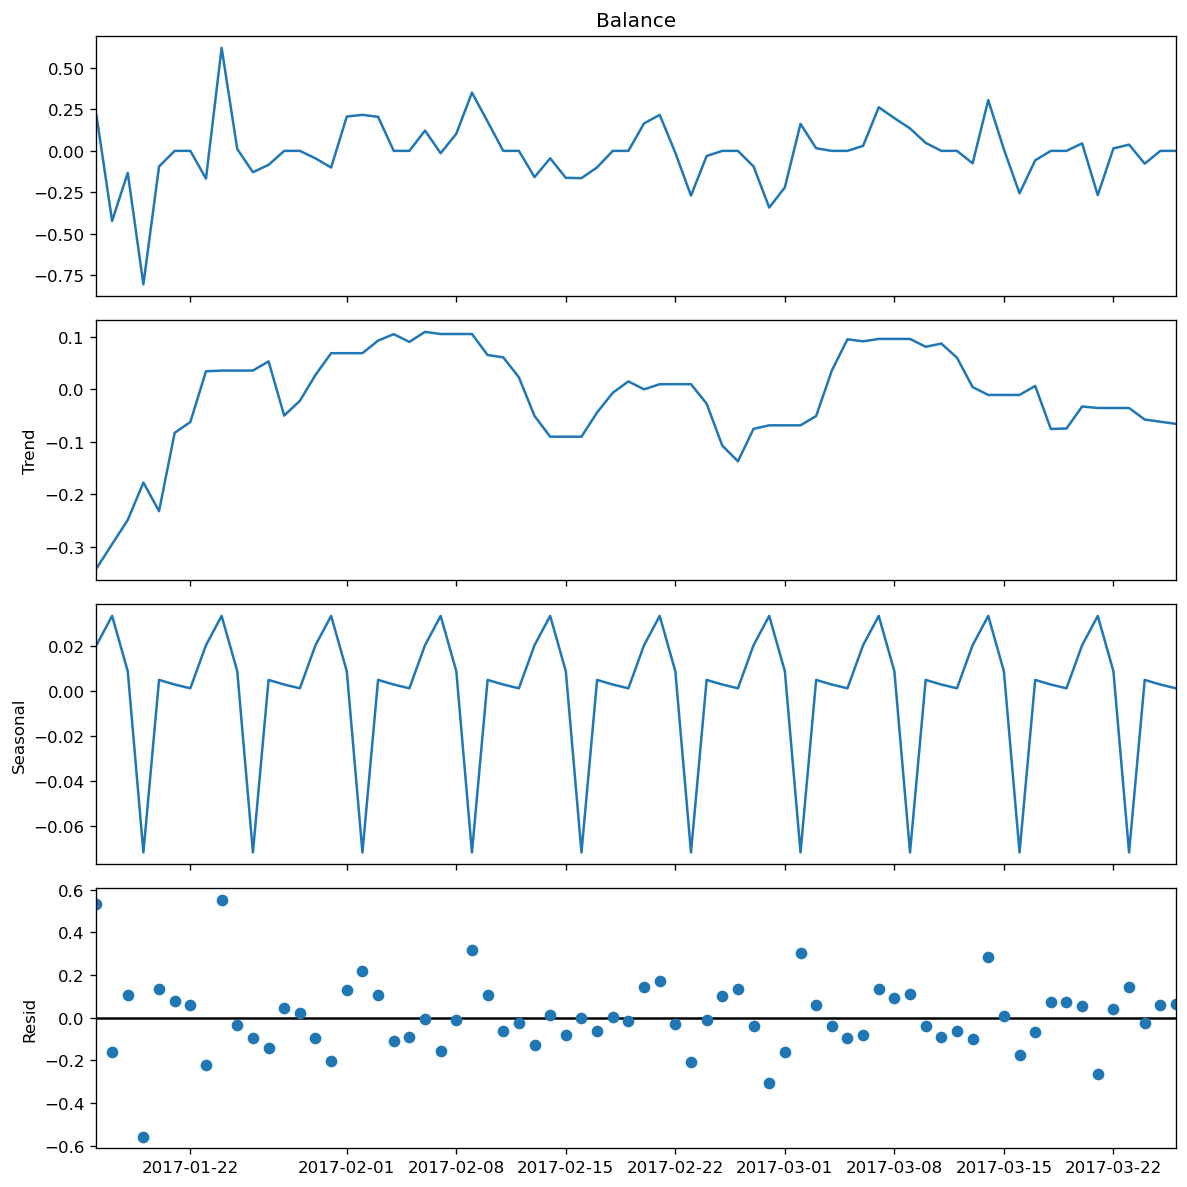

In [278]:
result_add = seasonal_decompose(df.shift7[7:77], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

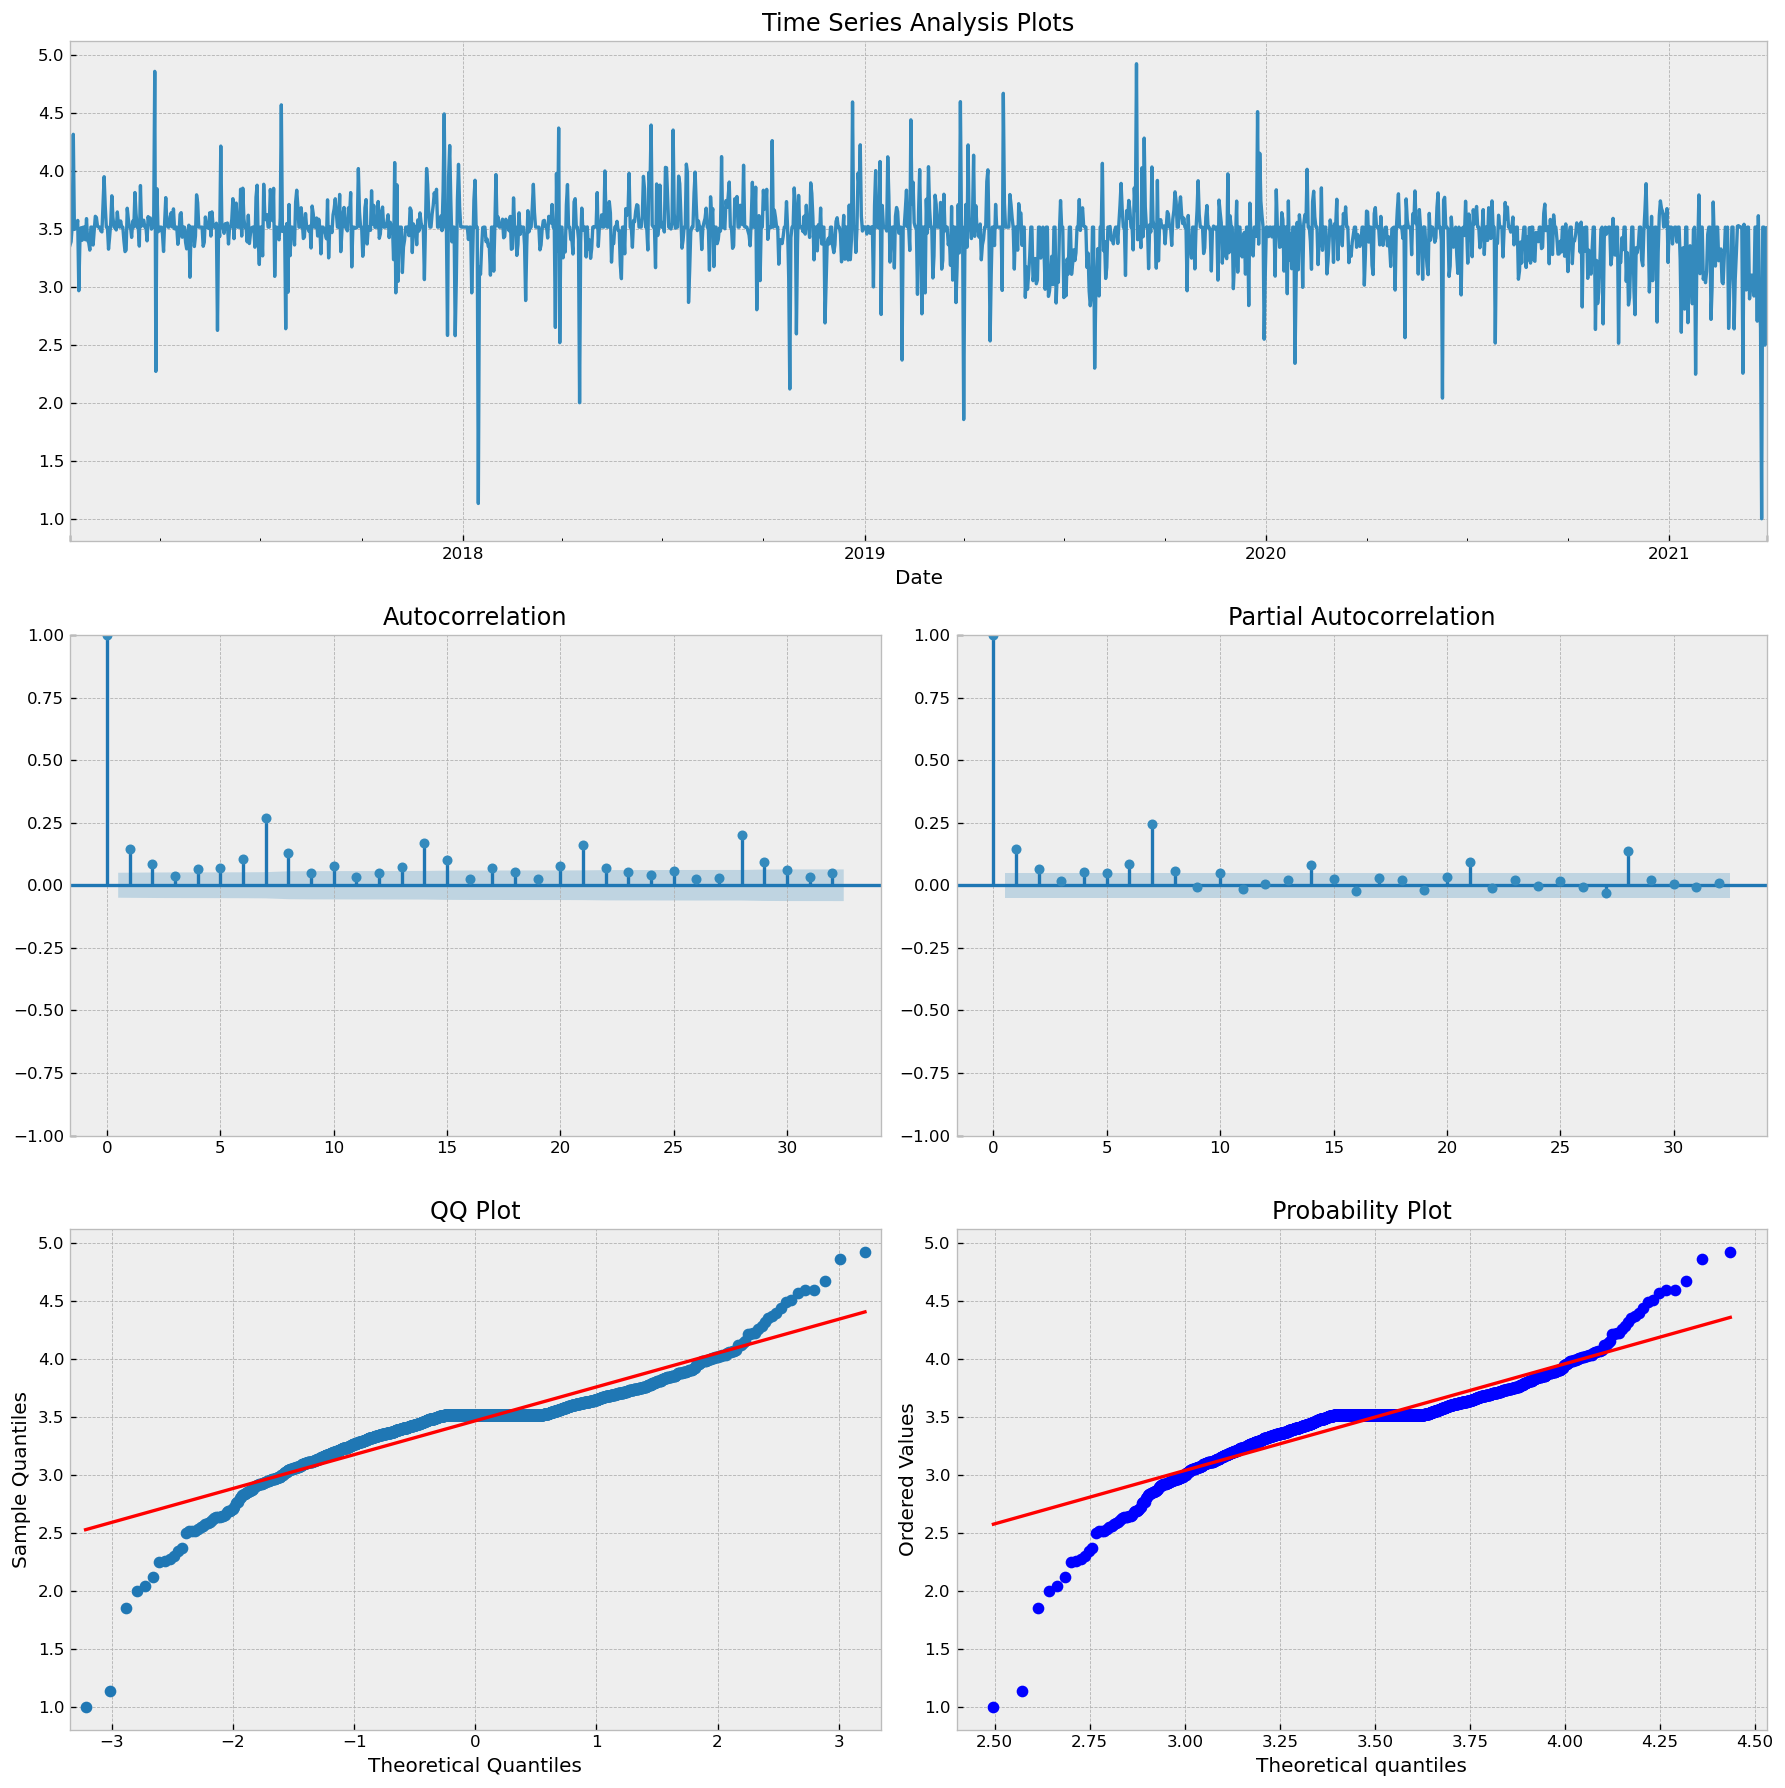

In [279]:
tsplot(df.posBalance)

# Моделирование

In [280]:
start_date = np.datetime64('2017-06-30')
threshold_date = np.datetime64('2019-07-30')
end_date = np.datetime64('2020-07-30')

In [281]:

ps = range(0, 2)
d = 0
qs = range(0, 2)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for p, q, P, Q in parameters_list:
    try:
        model_SARIMAX = ARIMA(endog=df.Balance[df.index >= threshold_date], order=(p, d, q), seasonal_order=(P, D, Q, 7))
        model_SARIMAX = model_SARIMAX.fit()
    except ValueError:
        print('wrong parameters:', (p,d,q,P,D,Q))
        continue
    mask = (df.index >= threshold_date) & (df.index <= end_date)
    predict=model_SARIMAX.predict(start=threshold_date, end=end_date)
    err_max = (df.Balance[mask]-predict).abs().max()
    err_mean = (df.Balance[mask]-predict).abs().mean()
    aic = model_SARIMAX.aic
    if aic < best_aic:
        best_model = model_SARIMAX
        best_err_max = err_max
        best_err_mean = err_mean
        best_combination = (p,d,q,P,D,Q)
        best_aic = aic
    results.append([p, d, q, P, D, Q, err_max, err_mean, aic])

In [282]:
best_combination

(1, 0, 1, 1, 1, 1)

In [283]:
result_table = pd.DataFrame(results)
result_table.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'err_max', 'err_mean', 'aic']
display(result_table.sort_values(by='aic', ascending=True))

,p,d,q,P,D,Q,err_max,err_mean,aic
15,1,0,1,1,1,1,1.396644,0.169908,85.192013
13,1,0,1,0,1,1,1.396613,0.171196,85.927398
11,1,0,0,1,1,1,1.383314,0.167311,91.039041
7,0,0,1,1,1,1,1.388580,0.167108,91.746667
9,1,0,0,0,1,1,1.408527,0.167765,94.103489
3,0,0,0,1,1,1,1.400122,0.164592,94.570952
5,0,0,1,0,1,1,1.414757,0.167491,94.918083
1,0,0,0,0,1,1,1.427617,0.164662,98.058413
10,1,0,0,1,1,0,1.254231,0.191575,222.079132
2,0,0,0,1,1,0,1.255022,0.189553,222.122911


In [285]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                         Balance   No. Observations:                  611
Model:             ARIMA(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood                 -37.596
Date:                         Fri, 29 Mar 2024   AIC                             85.192
Time:                                 20:50:54   BIC                            107.210
Sample:                             07-30-2019   HQIC                            93.761
                                  - 03-31-2021                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9337      0.060     15.666      0.000       0.817       1.050
ma.L1         -0.8671      0.074    -11.681      0.000      -1.013      -0.722
ar.S.L7        0.0795      0.048      1.658      0.097      -0.014       0.173
ma.S.L7       -0.9265      0.025    -37.463      0.000      -0.975      -0.878
sigma2         0.0650      0.002     37.530      0.000       0.062       0.068
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              3341.05
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -1.39
Prob(H) (two-sided):                  0.09   Kurtosis:                        14.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [286]:
import pmdarima as pm
model = pm.AutoARIMA(
                        test='adf',
                        start_p=0, end_p=2,
                        # start_d=0, end_d=2,
                        start_q=0, end_q=2,
                        start_P=0, end_P=2,
                        start_D=0, end_D=1,
                        start_Q=0, end_Q=2,
                        m=7,
                        seasonal=True,
                        stationary=True,
                        trace=True
                      ).fit(y=df.Balance[df.index >= threshold_date])

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=228.521, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=145.544, Time=0.24 sec


 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=167.849, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=302.917, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=216.517, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=130.708, Time=0.45 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=89.476, Time=0.97 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=91.397, Time=0.59 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=92.939, Time=1.19 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=88.339, Time=1.15 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=147.292, Time=0.36 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=167.169, Time=0.26 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=92.210, Time=1.31 sec
 ARIMA(2,0,0)(1,0,2)[7] intercept   : AIC=88.986, Time=1.28 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=82.034, Time=1.60 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=134.696, Time=1.10 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=82.695, Time=0.88 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept

In [287]:
mask = (df.index >= threshold_date) & (df.index <= end_date)
predict_auto=model.predict_in_sample(start=threshold_date, end=end_date)
err = (df.Balance[mask]-predict_auto).abs()
print(err.max(), err.mean())

1.4045967753165314 0.16256145602525113


In [293]:
mask = (df.index >= threshold_date) & (df.index <= end_date)
predict_chosen = best_model.predict(start=threshold_date, end=end_date)
err_chosen = (df.Balance[mask]-predict_chosen).abs()
print(err_chosen.max(), err_chosen.mean())

1.3966436909446198 0.16990801410259262


<Axes: xlabel='Date', ylabel='predicted_mean'>

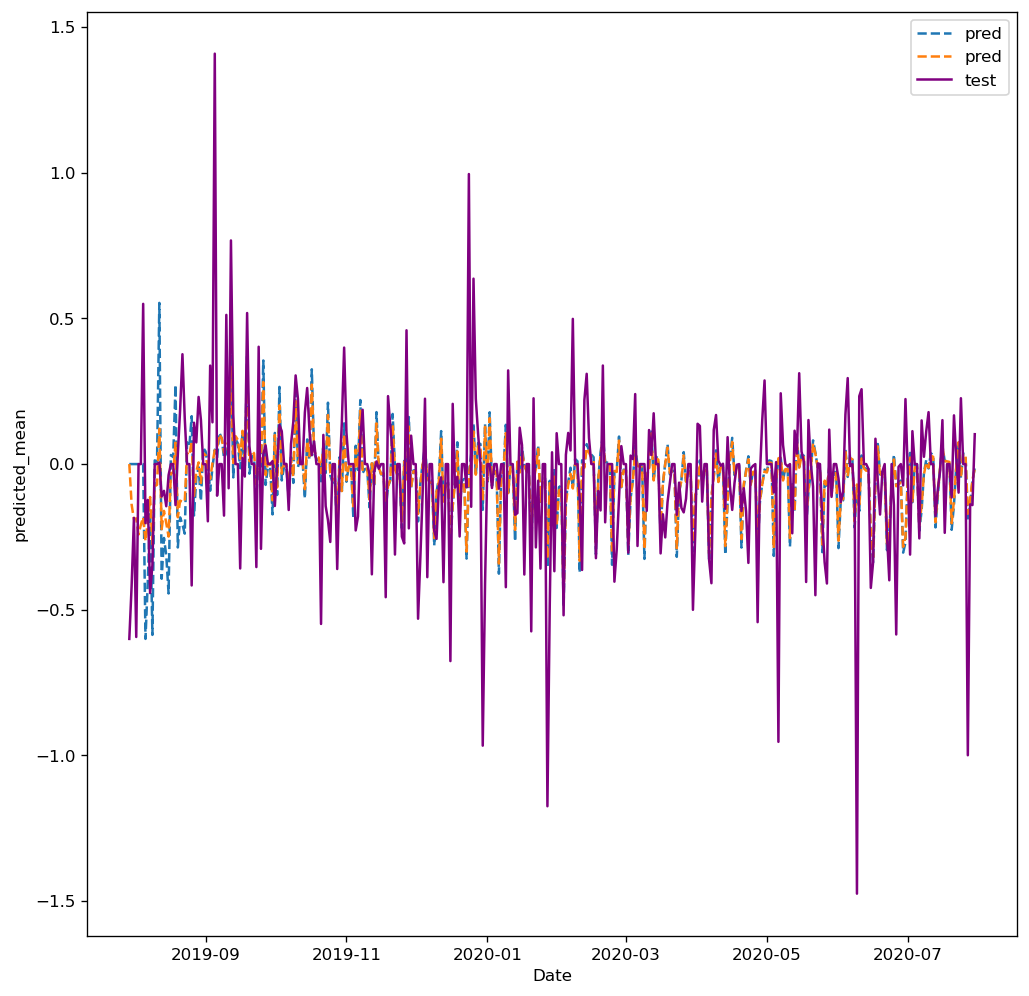

In [292]:
# sns.lineplot(y=df.posBalance[df.index < threshold_date], x=df.index[df.index < threshold_date], label='train')
sns.lineplot(x=df.index[mask], y=predict_chosen, label='pred', linestyle='dashed')
sns.lineplot(x=df.index[mask], y=predict_auto, label='pred', linestyle='dashed')
sns.lineplot(x=df.index[mask], y=df.Balance[mask], label='test', color = 'purple')

In [290]:
err = (df.posBalance[mask]-predict).abs()
print(err.max(), err.mean())

4.874395726595382 3.514356892523802


<Axes: xlabel='Date'>

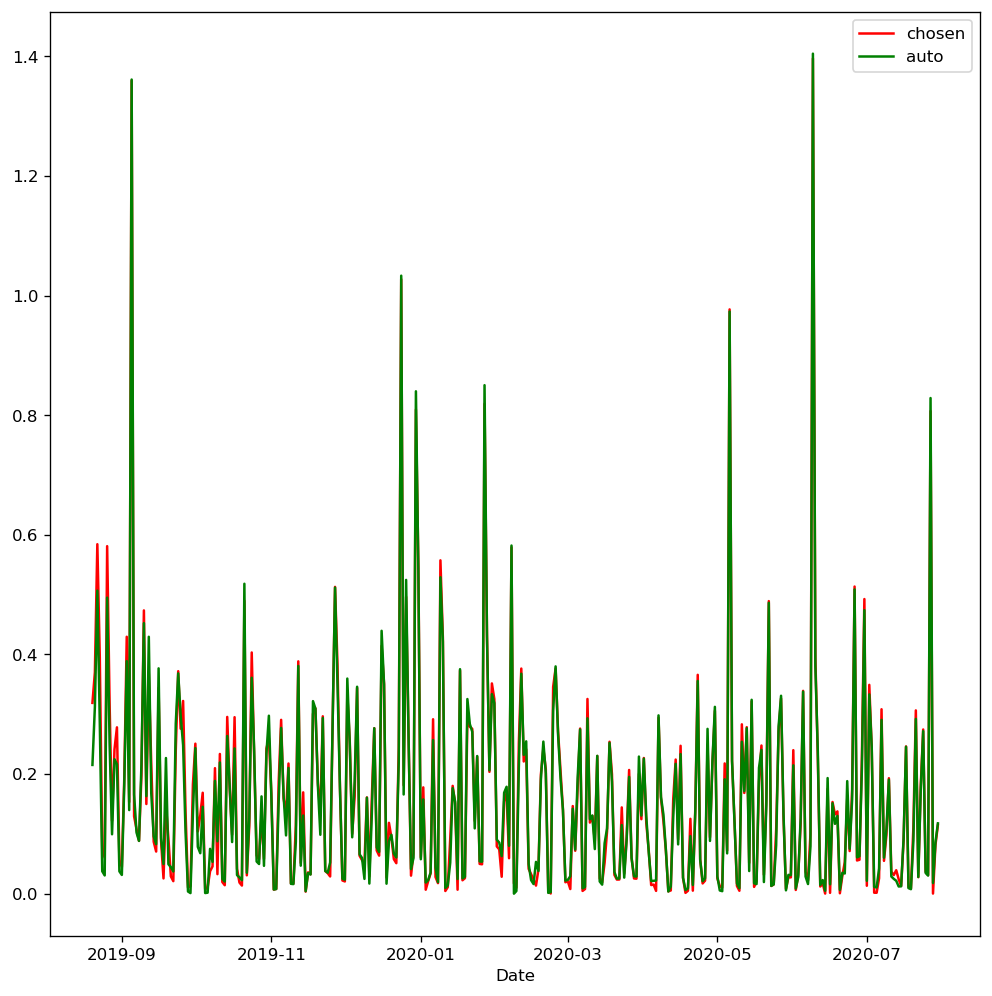

In [301]:
sns.lineplot(x=df.index[mask][21:], y=(df.Balance[mask]-predict_chosen)[21:].abs(), label='chosen', color = 'red')
sns.lineplot(x=df.index[mask][21:], y=(df.Balance[mask]-predict_auto)[21:].abs(), label='auto', color = 'green')

# sns.lineplot(x=df.index[mask][21:], y=df.Balance[mask][21:], label='test', color = 'purple')